In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load CSVs
path = './DataBags/drifting3_3'

# Linear
ackermann = pd.read_csv(f'{path}/ackermann.csv')
odomfil = pd.read_csv(f'{path}/odomfil.csv')

# Angular
imu = pd.read_csv(f'{path}/imu.csv')

FileNotFoundError: [Errno 2] No such file or directory: './DataBags/drifting3_3/ackermann.csv'

# Linear

In [ ]:
throttle_sorted = ackermann.sort_values(['sec', 'nanosec'], ignore_index=True)
odomfil_sorted = odomfil.sort_values(['sec', 'nanosec'], ignore_index=True)

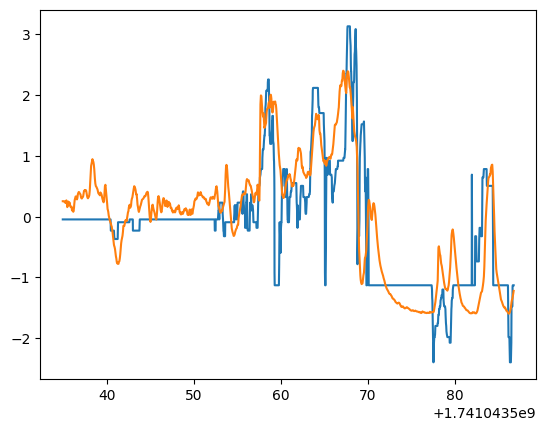

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import atan2, asin

# Scale throttle['speed'] and odom velocity
scaler = StandardScaler()
scaler.fit(throttle_sorted['speed'].values.reshape(-1, 1))
throttle_scaled = scaler.transform(throttle_sorted['speed'].values.reshape(-1, 1)).squeeze(axis=-1)

# Combine x and y
odomfil_comb = np.sqrt((odomfil_sorted['twist_linear_y'] ** 2) + (odomfil_sorted['twist_linear_x'] ** 2))

scaler.fit(odomfil_comb.values.reshape(-1, 1))
odomfil_scaled = scaler.transform(odomfil_comb.values.reshape(-1, 1)).squeeze(axis=-1)

# Resample to same length
odomfil_scaled = np.interp((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), (odomfil_sorted['sec'] + odomfil_sorted['nanosec'] * 10**-9), odomfil_scaled)
odomfil_position_x = np.interp((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), (odomfil_sorted['sec'] + odomfil_sorted['nanosec'] * 10**-9), odomfil_sorted['position_x'])
odomfil_position_y = np.interp((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), (odomfil_sorted['sec'] + odomfil_sorted['nanosec'] * 10**-9), odomfil_sorted['position_y'])

plt.plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), throttle_scaled)
plt.plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), odomfil_scaled)

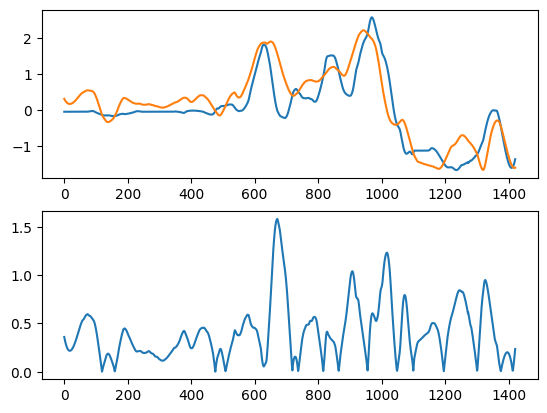

In [ ]:
# Plot the difference
from scipy.signal import savgol_filter

fig, axs = plt.subplots(2)

axs[0].plot(savgol_filter(throttle_scaled, 100, 3))
axs[0].plot(savgol_filter(odomfil_scaled, 100, 3))

axs[1].plot(np.abs(savgol_filter(throttle_scaled, 100, 3) - savgol_filter(odomfil_scaled, 100, 3)))

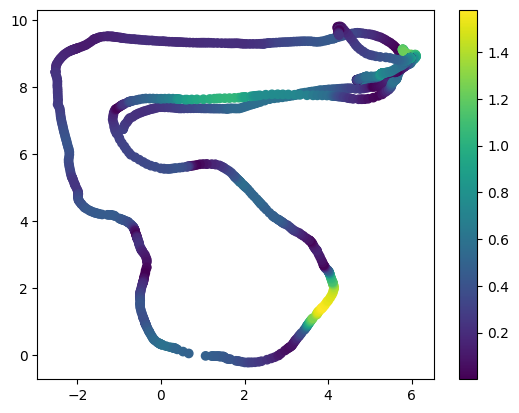

In [ ]:
plt.scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(throttle_scaled, 100, 3) - savgol_filter(odomfil_scaled, 100, 3))))
plt.colorbar()

# Angular

In [ ]:
wheelbase = 0.32
ackermann['angular_vel'] = ackermann['speed'] * (np.tan(ackermann['steering_angle']) / wheelbase)

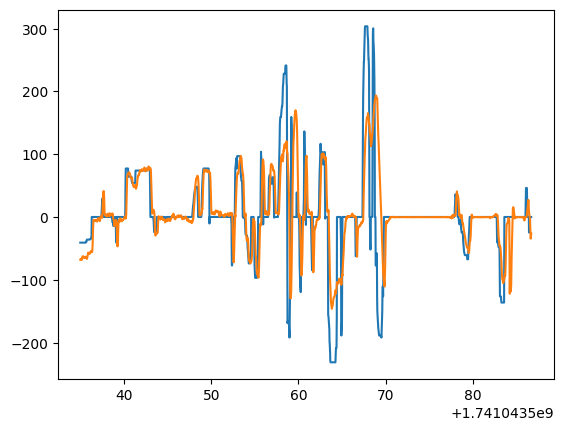

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import atan2, asin

imu_sorted = imu.sort_values(['sec', 'nanosec'], ignore_index=True)
ackermann_sorted = ackermann.sort_values(['sec', 'nanosec'], ignore_index=True)

# Resample to same length
imu_resampled = np.interp((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), (imu_sorted['sec'] + imu_sorted['nanosec'] * 10**-9), imu_sorted['twist_angular_z'])

plt.plot((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), np.rad2deg(ackermann_sorted['angular_vel']))
plt.plot((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), imu_resampled)

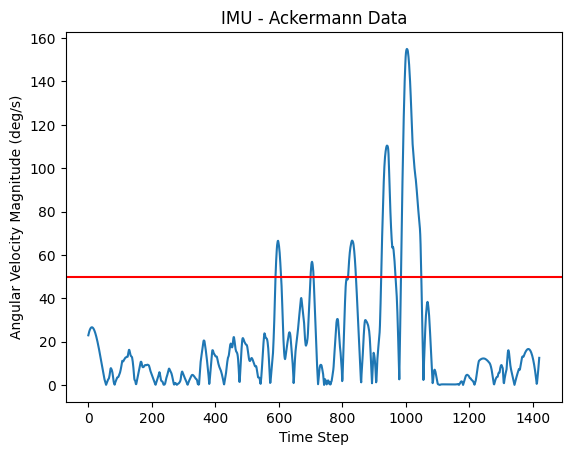

In [ ]:
plt.plot(np.abs(savgol_filter(imu_resampled, 100, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 100, 3)))
plt.title('IMU - Ackermann Data')
plt.xlabel('Time Step')
plt.ylabel('Angular Velocity Magnitude (deg/s)')
plt.axhline(50, c='red')
plt.savefig('subtracted.pdf')

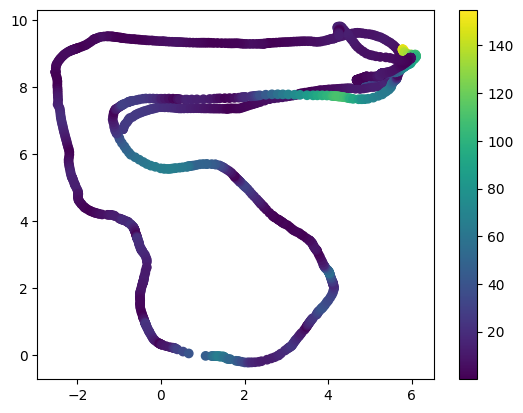

In [ ]:
plt.scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(imu_resampled, 100, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 100, 3))))
plt.colorbar()

# Both

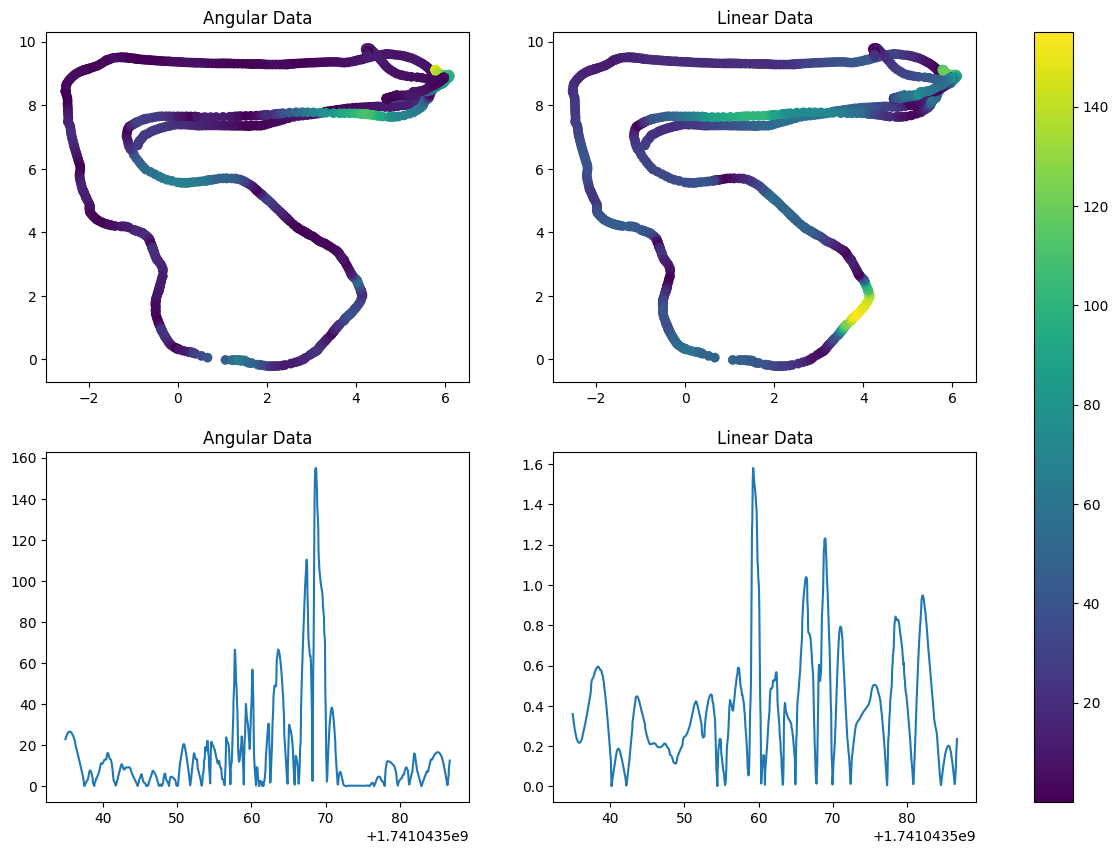

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(imu_resampled, 100, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 100, 3))))
axs[0, 0].set_title('Angular Data')

axs[0, 1].scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(throttle_scaled, 100, 3) - savgol_filter(odomfil_scaled, 100, 3))))
axs[0, 1].set_title('Linear Data')

axs[1, 0].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), np.abs(savgol_filter(imu_resampled, 100, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 100, 3)))
axs[1, 0].set_title('Angular Data')

axs[1, 1].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), np.abs(savgol_filter(throttle_scaled, 100, 3) - savgol_filter(odomfil_scaled, 100, 3)))
axs[1, 1].set_title('Linear Data')

fig.colorbar(axs[0, 0].collections[0], ax=axs, orientation='vertical')